In [1]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot
import numpy as np
import os
import textwrap
import itertools
import ants
import warnings

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/ants/regrid/esmf.py:26: UserWarning:  No module named 'ESMF'
Proceeding without capabilities provided by ESMPy (ESMF).
  warnings.warn(msg.format(str(_ESMF_IMPORT_ERROR)))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/ants/regrid/_ugrid.py:19: UserWarning:  No module named 'ESMF'
Proceeding without capabilities provided by ESMPy (ESMF).
  warnings.warn(msg.format(str(_ESMF_IMPORT_ERROR)))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/iris/experimental/raster.py:29: IrisDeprecation: iris.experimental.raster is deprecated since version 3.2, and will be removed in a future release. If you make use of this functionality, please contact the Iris Developers to discuss how to retain it (which may involve reversing the deprecation).
  warn_deprecated(wmsg)


In [2]:
home_dir=os.environ['HOME']
HOME=Path(home_dir)

In [3]:
# Find all regions for a given rose-id
ROSE ='u-dl705'
REGION_DIRS = [ d for d in list((HOME / 'cylc-run' / ROSE / 'share/data/ancils/' ).glob('*')) if d.is_dir() ]
REGION_DIRS                                                           

[PosixPath('/home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k')]

In [4]:
# Find all resolutions for a given REGION
for r_dir in REGION_DIRS:
    RESOLUTION_DIRS = [ d for d in list((r_dir).glob('*')) if d.is_dir() ]

In [5]:
RESOLUTION_DIRS

[PosixPath('/home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k/CAPE-k_11p1'),
 PosixPath('/home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k/CAPE-k_era5'),
 PosixPath('/home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k/CAPE-k_5'),
 PosixPath('/home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k/CAPE-k_1')]

Plotting land_binary_mask for CAPE-k_11p1
Plotting land_binary_mask for CAPE-k_era5
Plotting land_binary_mask for CAPE-k_5
Plotting land_binary_mask for CAPE-k_1


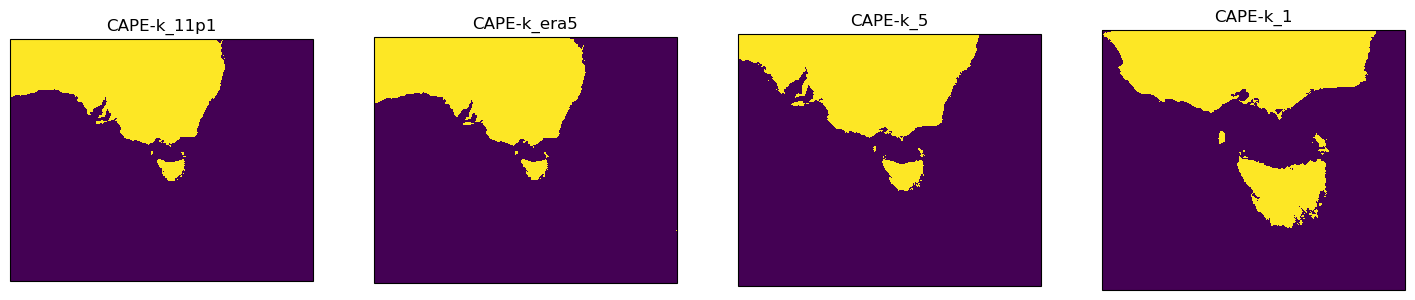

In [10]:
# quick check - plot and store land-sea masks for these resolutions
# Ignore warnings from mule  and iris 
warnings.filterwarnings('ignore',module='mule') 
warnings.filterwarnings('ignore',module='iris') 

num_plots = len(RESOLUTION_DIRS)

lsm_masks = {}

fig,ax = plt.subplots(1,num_plots,subplot_kw={'projection': ccrs.PlateCarree()},figsize=[18,8])

for i,R in enumerate(RESOLUTION_DIRS):
    MASK_FILE = R / 'qrparm.mask'
    mask_cubes = ants.load(MASK_FILE)

    # Select the cube corresponding to 'land_binary_mask'
    lbm_cube, = [ cube for cube in mask_cubes if cube.name() == 'land_binary_mask'] 
    print (f'Plotting land_binary_mask for {R.name}')
    
    iris.plot.pcolormesh(lbm_cube,axes=ax[i])
    ax[i].set_title(f'{R.name}')

    # Store the masks for later analysis
    lsm_masks[R.name] = xr.DataArray.from_iris(lbm_cube)

In [11]:
# Now create dictionaries for all ancillary parameter files for each resolution
parm_files = {}

for i,R in enumerate(RESOLUTION_DIRS):
    
    all_files = list(R.glob('qrparm*'))

    # Filter out symlinks
    files = []
    [ files.append(f) for f in all_files if not f.is_symlink() ]

    parm_files[R.name] = files

In [12]:
# Get total list of fields for each resolution
num_plots = {}

# Loop over LAM resolutions
for res in parm_files.keys():

    count = 0
    # Loop over each ancillary parameter file for this resolution
    for file in parm_files[res]:
        #print (f'INFO : Loading {file}')
        try:
            cube = ants.load(file)
            #print (cube)
            count += len(cube)
        except:
            print (f'ERROR : Unable to open {file}\nERROR : You will have to manually check this file using "xconv" ')
            continue

    num_plots[res] = count
    print (f'There are {num_plots[res]} fields for {res}')
    

ERROR : Unable to open /home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k/CAPE-k_11p1/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 67 fields for CAPE-k_11p1
ERROR : Unable to open /home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k/CAPE-k_era5/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 67 fields for CAPE-k_era5
ERROR : Unable to open /home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k/CAPE-k_5/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for CAPE-k_5
ERROR : Unable to open /home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k/CAPE-k_1/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for CAPE-k_1


In [13]:
# Some logic to collapse multi-level cubes for simple plotting. It is assumed that any gross
# errors in the ancillaries (e.g. NaNs) will remain after the averaging

def collapse_cube(file,
                  cube):
    """
    Collapse a cube onto lat/lon dimensions via averaging
    """
    collapse_dims = []
    
    for coord in cube.coords():
        if coord not in cube.dim_coords:
            collapse_dims.append(coord.name())
            print (f'For {file.name} {cube.name()} coordinate {coord.name()} will be collapsed')
            
    # Check if time remains
    if 'time' in [ c.name() for c in cube.dim_coords ]: 
        collapse_dims.append('time')
        print (f'For {file.name} variable {cube.name()} coordinate time will be collapsed')
    new_cube = cube.collapsed(collapse_dims,iris.analysis.MEAN)

    return new_cube

In [14]:
# These ancillaries have a land-sea mask (i.e. ocean regions are already full of NaNs)
land_file_types = ['soil', 'veg', 'hydtop','MORUSES' ] 

In [15]:
# Set up diagnostic plotting for each resolution

def plot_ancils(region,
                files,
                num_plots,
                plot=True,
                num_columns=4,
                lat_range=[],
                lon_range=[],
                ):
    """
    Plot ancillaries fields for a given LAM resolution
    Check for the existence of NaNs and return these fields as a list
    of data_arrays
    """

    nan_fields = []
    
    num_rows = num_plots // num_columns
    
    if num_plots % num_columns != 0:
        num_rows += 1
    
    Position = range(1,num_plots+1)
    
    fig_height = num_rows*3
    fig_width = 15
    max_label_length=30

    print (f' Plotting ancillary parameters for {region}\n')
    
    fig = plt.figure(figsize=(fig_width,fig_height))
    k = 0
    
    # Loop over all ancillary files
    
    for file in files:
        try:
            cubes = ants.load(file)
        except:
            print (f'ERROR : Unable to open {file}')
            continue
    
        # Loop over all variables in cube
        for cube in cubes:
            ax = fig.add_subplot(num_rows, num_columns, Position[k])
    
            if len(cube.shape) > 2: 
                # Need to reduce dimension
                cube = collapse_cube(file,cube)
                
            da = xr.DataArray.from_iris(cube)
    
            # Find NaNs
            all_mask = da.isnull()
            
            # Check if this ancillary already has a land-sea mask
            if any(t in str(file) for t in land_file_types):
                # Remove the ocean from the NaN search
                all_mask = lsm_masks[region] & da.isnull()
        
            if all_mask.compute().sum() > 0:   
                print (f'ERROR : NaNs identified in {cube.name()},{file.name}')
                nan_fields.append(da)
            
            if 'standard_name' in da.attrs.keys():
                split = textwrap.wrap(da.attrs['standard_name'].replace('_',' '),max_label_length)
                label = '\n'.join(split)
                cb_args = {'label': label}
            else:
                cb_args = {'label':da.attrs['STASH']}

            # Plot according to specified lat/lon ranges
            if lat_range and lon_range:
                da.sel(latitude=slice(lat_range[0],lat_range[1]),
                       longitude=slice(lon_range[0],lon_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            elif lat_range:
                da.sel(latitude=slice(lat_range[0],lat_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            elif lon_range:
                da.sel(longitude=slice(lon_range[0],lon_range[1]))\
                       .plot(ax=ax,cbar_kwargs=cb_args)
            else:
                da.plot(ax=ax,cbar_kwargs=cb_args)
            ax.set_title(file.name)
            k += 1

    fig.suptitle(f'Ancillary parameter fields for {region}',fontsize=20,y=1.0)
    plt.tight_layout()

    return nan_fields

 Plotting ancillary parameters for CAPE-k_11p1

For qrparm.veg.func_igbp canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp canopy_height coordinate month will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate month will be collapsed
For qrparm.veg.func canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func variable canopy_height coordinate time will be collapsed
For qrparm.veg.func leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func variable leaf_area_index coordinate time will be collapsed
ERROR : Unable to open /home/548/ab4502/cylc-run/u-dl705/share/data/ancils/CAPE-k/CAPE-k_11p1/qrparm.veg.dist
For qrparm.veg.frac_igbp m01s00i216 coordinate pseudo_level will be collapsed
For qrparm.veg.frac_cci_pre_c4 m01s00i216 coordinate pseudo_level will be collapsed
For qrparm.veg.frac_cci m01s00i216 coordinate pseudo_lev

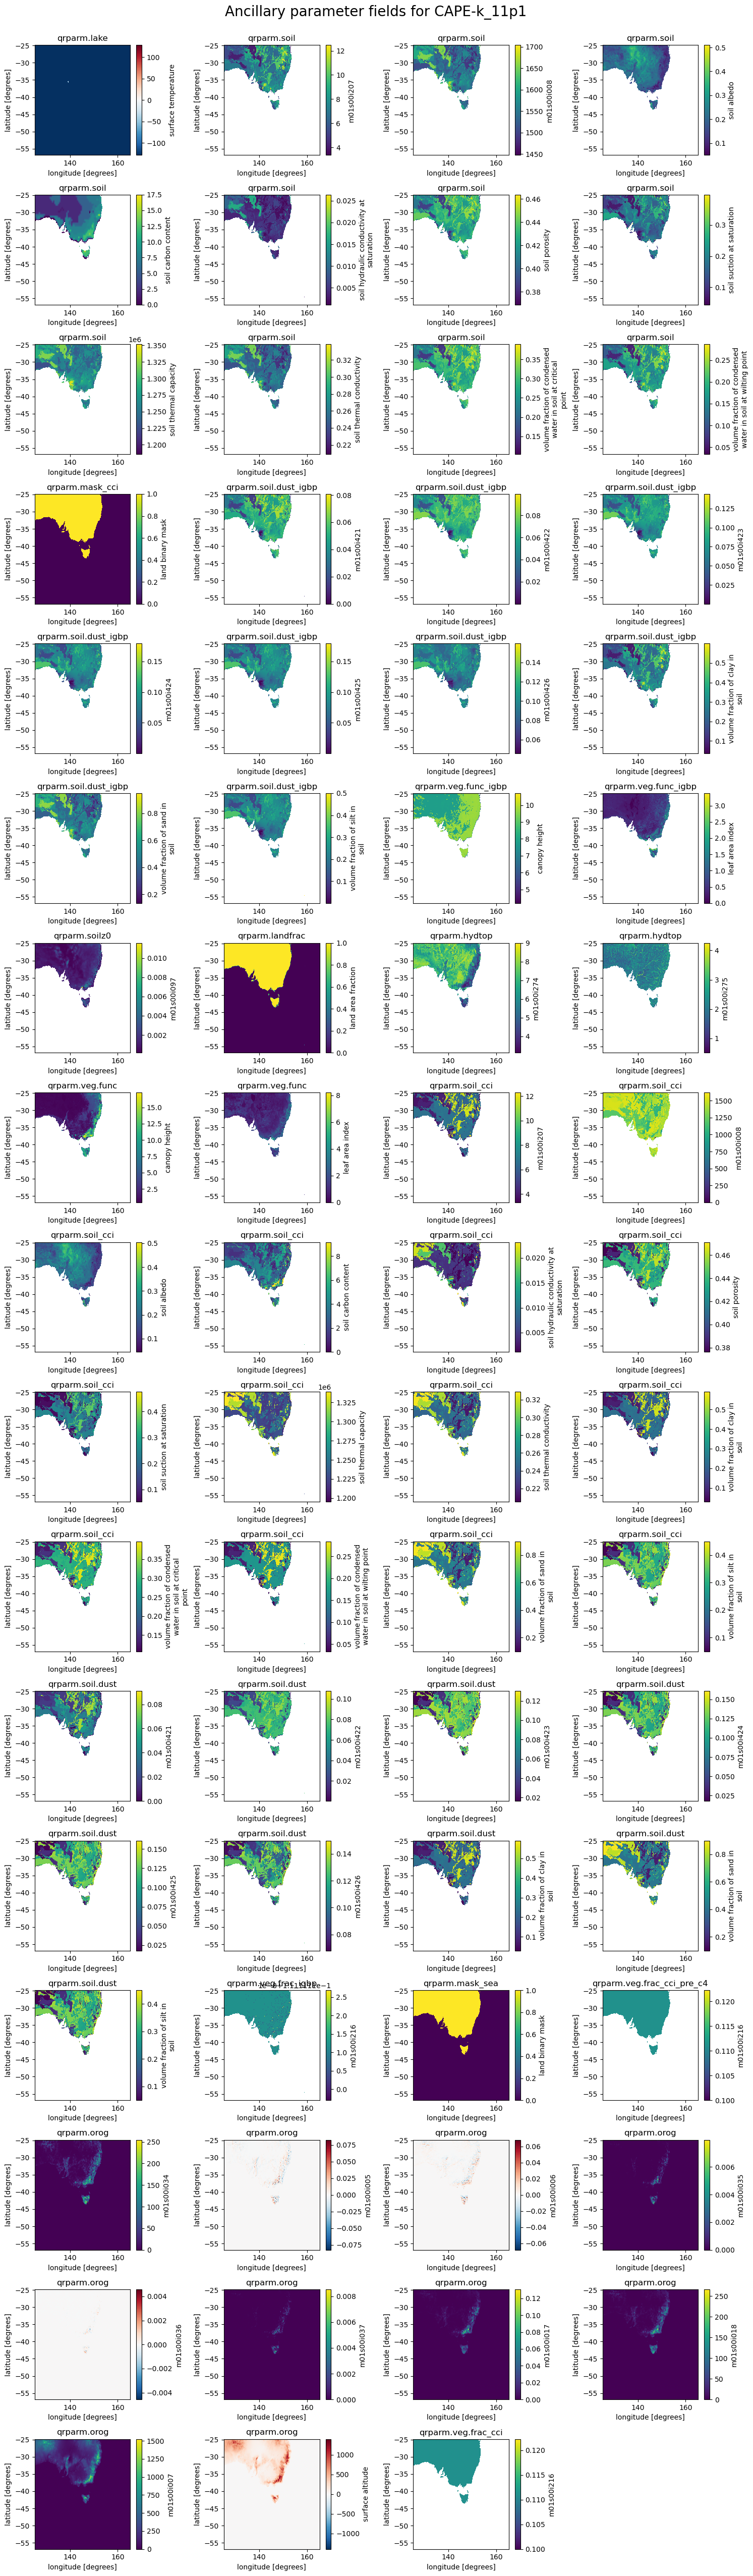

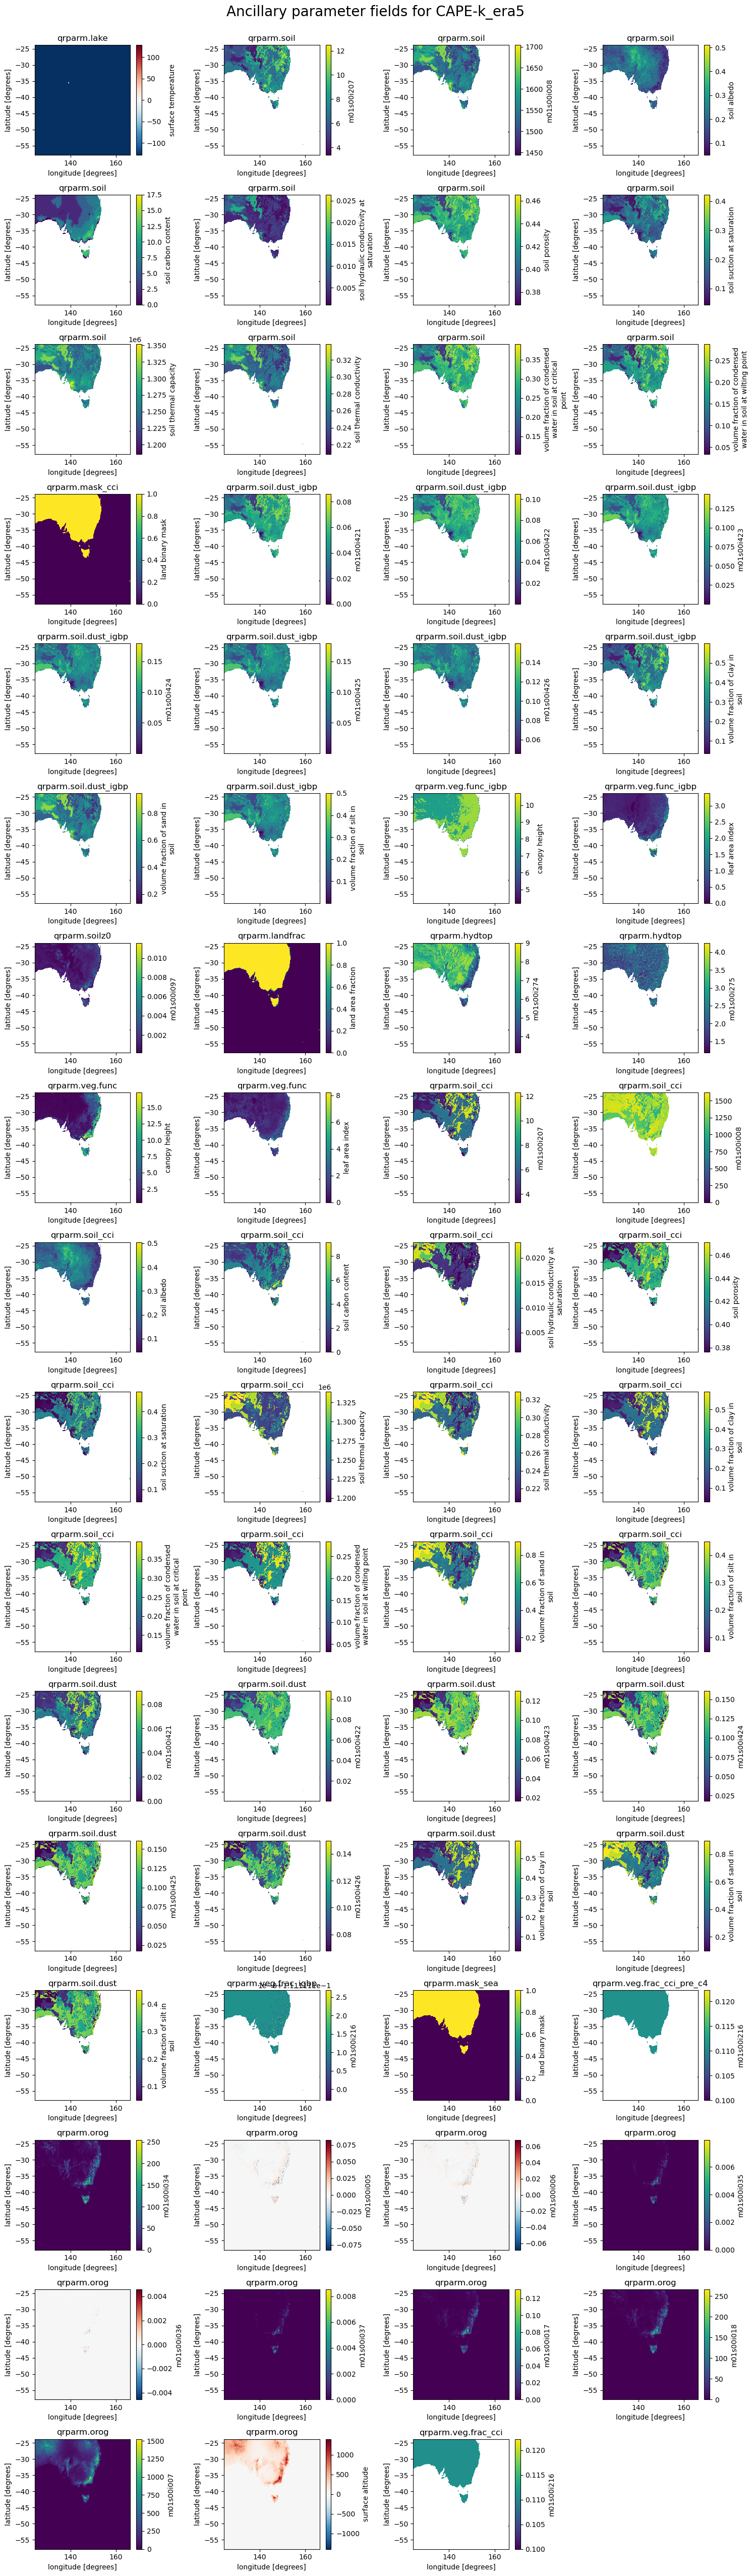

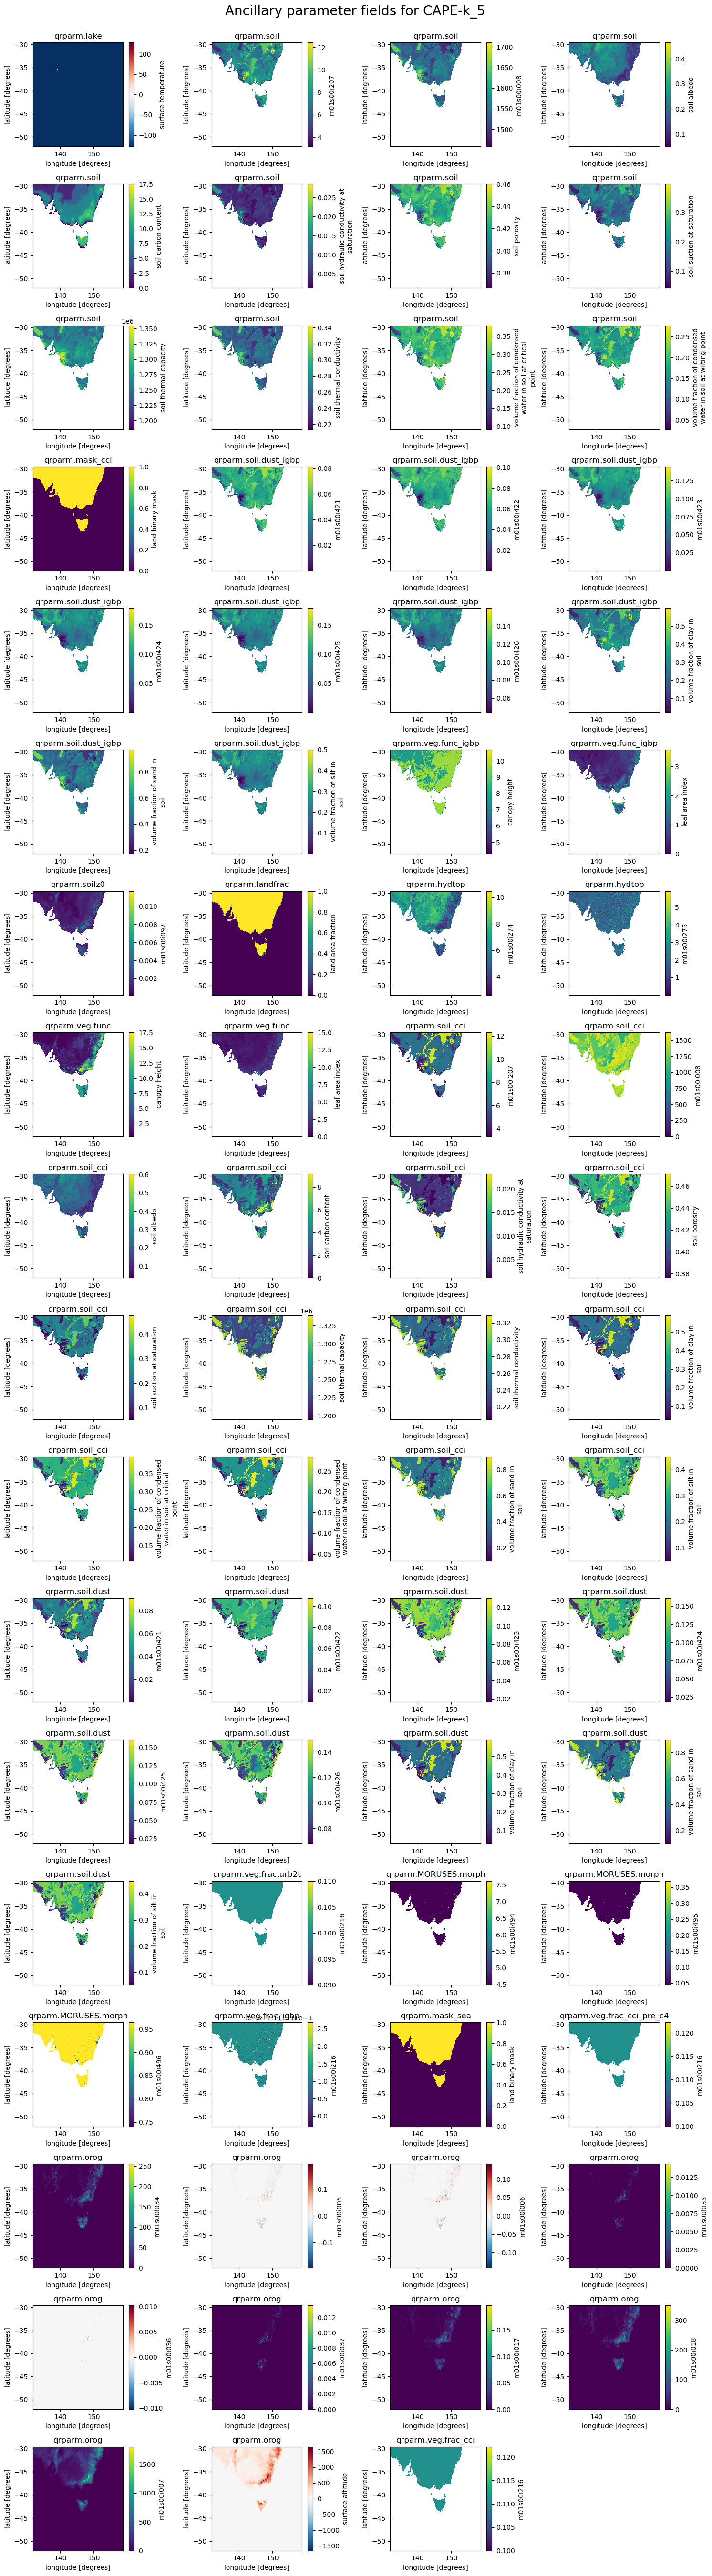

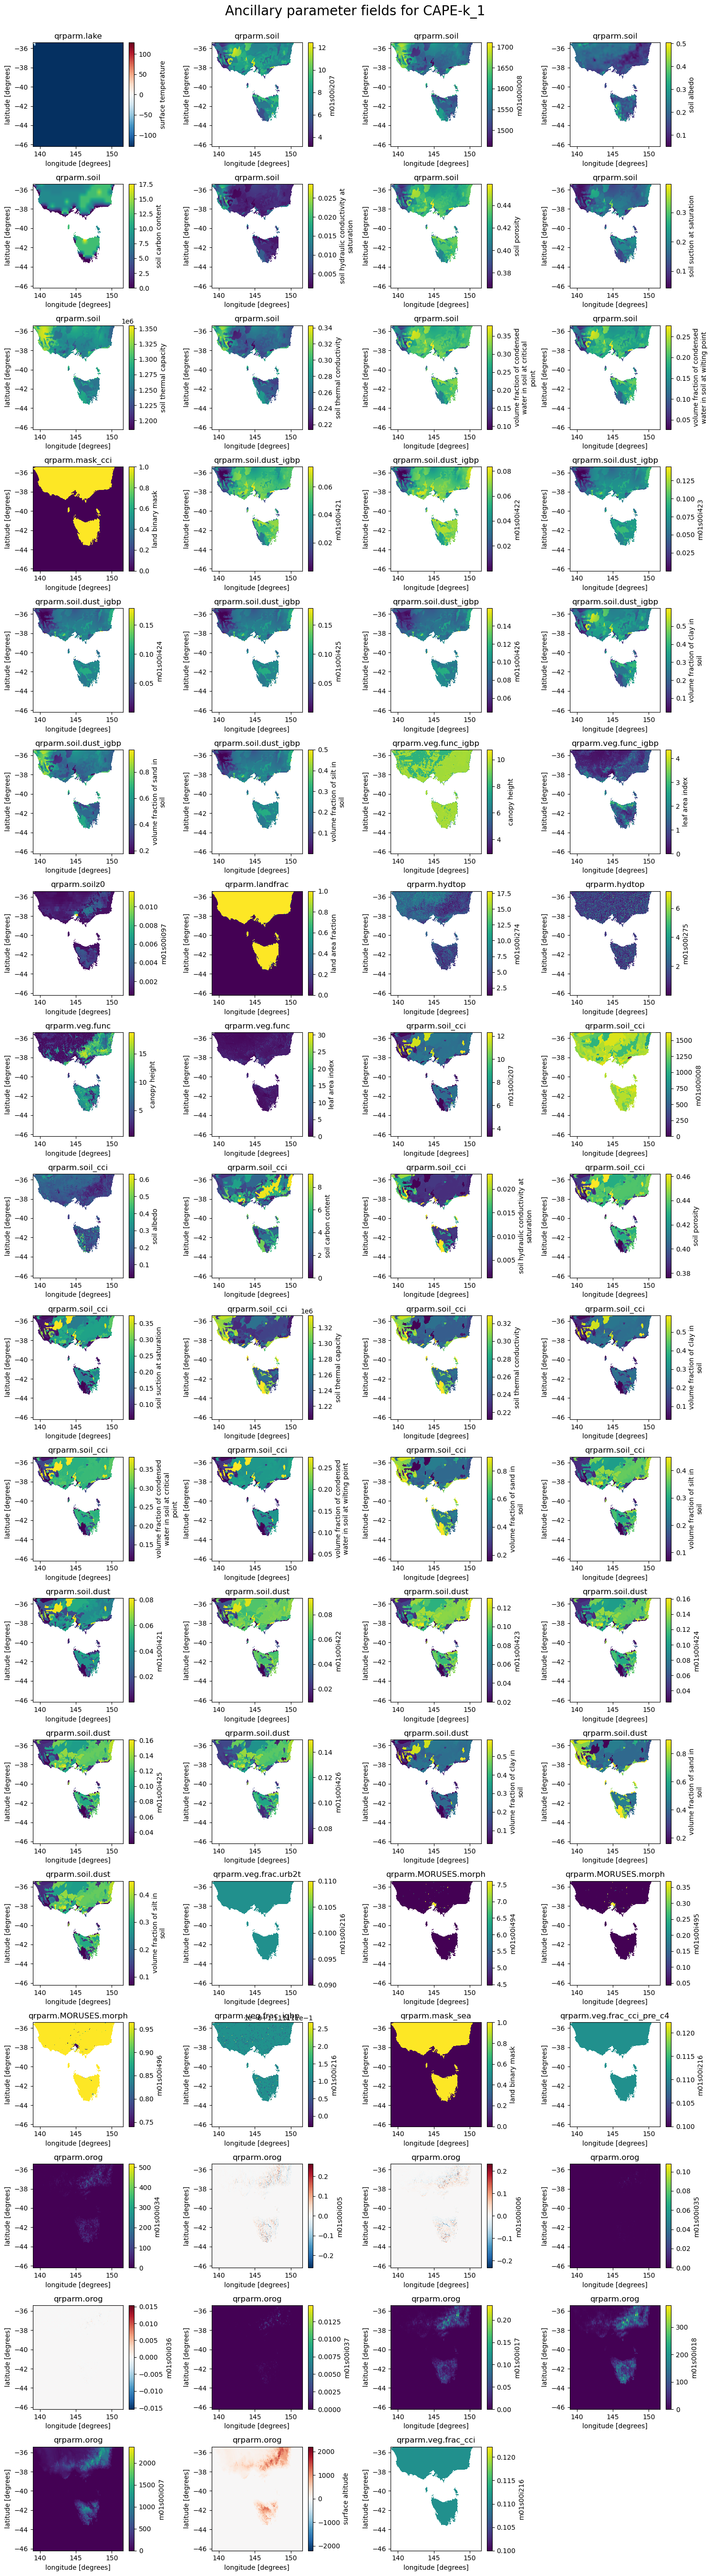

In [20]:
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
#for res in parm_files.keys():
for res in parm_files.keys():
    nan_ancils = plot_ancils(res,
                             parm_files[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)

In [23]:
print(bad_ancils)

[]
